In [1]:
import pandas as pd
import networkx as nx
import statistics as st
import numpy as np
from copy import copy
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import random
import seaborn as sns
from itertools import combinations

# 1. Data Preprocessing

The main focus of the following preprocessing steps is to remove the discrepancies between the names among the three datasets. Analising the data it can be seen that the last character of almost every row in the $heronetwork$ dataset should be removed (with 2 exeptions), also the name of $spiderman$ needed to be standardized for all three datasets.  
Other actions were performed to add some columns to the $heronetwork$, such as the weights and a label, in preparation for the next part.  
The weight of an edge/collaboration will be the inverse of the number of that collaborations, including the mirrored rows.

In [2]:
edges = pd.read_csv("edges.csv")
nodes = pd.read_csv("nodes.csv")
network = pd.read_csv("hero-network.csv")
nodes.loc[nodes["node"]=="SPIDER-MAN/PETER PARKERKER", "node"] = "SPIDER-MAN/PETER PA"
edges.loc[edges["hero"]=="SPIDER-MAN/PETER PARKER", "hero"] = "SPIDER-MAN/PETER PA"
def lastcharem(x):
    if x == "SABRE": return x
    if x == "BLADE": return x
    else:
        y = list(x)
        del y[-1]
        return "".join(y)

In [3]:
herolist_nodes = nodes["node"].loc[nodes["type"]=="hero"].tolist()
nethero1list = network.hero1.tolist()
hero1discrepancy = (list(set(nethero1list) - set(herolist_nodes)))
nethero2list = network.hero2.tolist()
hero2discrepancy = (list(set(nethero2list) - set(herolist_nodes)))

In [4]:
network.loc[network.hero1.isin(hero1discrepancy), "hero1"] = network.loc[network.hero1.isin(hero1discrepancy), "hero1"].apply(lambda row: lastcharem(row))
network.loc[network.hero2.isin(hero1discrepancy), "hero2"] = network.loc[network.hero2.isin(hero2discrepancy), "hero2"].apply(lambda row: lastcharem(row))
network.drop(network[network.hero1==network.hero2].index, inplace=True)

In [5]:
network["idx"] = 1
dictionary1 = network.groupby(["hero1","hero2"]).count().to_dict(orient="dict")

def weight(x, y, d1):
    output = []
    if (x,y) in d1["idx"]: output.append(d1["idx"][(x,y)])
    if (y,x) in d1["idx"]: output.append(d1["idx"][(y,x)])
        
    return 1/(sum(output))


In [6]:
# final weights
network["weight"] = network.apply(lambda row: weight(row["hero1"], row["hero2"], dictionary1), axis=1)
# extra label
edges["label"] = edges.apply(lambda row: row.hero+" | "+row.comic, axis=1)
network["label"] = network.apply(lambda row: row.hero1+" | "+row.hero2, axis=1)

In [7]:
network.to_pickle("network")
nodes.to_pickle("nodes")
edges.to_pickle("edges")

# 2. Backend

### Controller
The controller creates the two graphs from the processed data, asks the user to select the functionality of interest, then executes it and saved the results in a variable. Regarding the subgraph of the second graph we opted to build it taking, alongside the top N heroes defined in the instructions, the comics in which they appear.

In [8]:
# Graphs initialization:
network = pd.read_pickle("network")
nodes = pd.read_pickle("nodes")
edges = pd.read_pickle("edges")

# First graph
G = nx.MultiGraph()
network.apply(lambda row: G.add_edge(row["hero1"], row["hero2"], weight=row["weight"], label=row["label"] ), axis=1) 
G_1 = nx.Graph(G)

# Second graph
G_2 = nx.Graph()
nodes.apply(lambda row: G_2.add_node(row["node"], kind = row["type"]), axis=1)
edges.apply(lambda row: G_2.add_edge(row["hero"], row["comic"], label=row["label"]), axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
96099    None
96100    None
96101    None
96102    None
96103    None
Length: 96104, dtype: object

In [9]:
# generation of the subgraphs
def sub_g1(G_1,N):
    topheroes = edges.groupby("hero",as_index=False).count().sort_values(by="comic",ascending=False).head(N).hero.tolist()    
    G = G_1.subgraph(topheroes)
    return G

def sub_g2(G_2,N):
    topheroes = edges.groupby("hero",as_index=False).count().sort_values(by="comic",ascending=False).head(N).hero.tolist()
    topcomics = edges.loc[(edges.hero.isin(topheroes))].groupby("hero", as_index=False).head(N//3).comic.tolist()
    G = G_2.subgraph(topheroes+topcomics)
    return G

### Functionality 1
This function extracts the features of the selected graph.  
Its structure is split in two, only one of the two part will be executed depending on the graph type. For the second graph some features were split for the two types of nodes.

In [10]:
def Functionality_1(G, graphtype):
    
    if graphtype == 1:
        
        # Number of nodes
        number_nodes = len(G.nodes())   
        #The number of collaborations of each superhero with the others (only if type 1)
        co_list = {}
        for i in G.nodes():
            co_list[i] = G.degree[i]       
        # density
        d = nx.density(G)
        # degree distribution
        deg_distro = []
        for i in G.nodes():
            deg_distro.append(G.degree[i])
        deg_distro_2 = []
        # mean degree
        mean_deg = sum(deg_distro)/len(deg_distro)
        mean_deg_2 = []
        # hubs
        hubvalue = np.percentile(deg_distro, 95)
        hubs = [k for k in G.nodes if G.degree[k] > hubvalue]
        # sparsity
        if nx.density(G) >= 0.5:
            sparsity = "Dense"
        else: sparsity = "Sparse"

    if graphtype == 2:
        
        # Number of nodes    
        comicsublist = [k for k,v in G.nodes(data=True) if v["kind"] == "comic"]
        herosublist = [k for k,v in G.nodes(data=True) if v["kind"] == "hero"]
        number_comicnode = len(comicsublist)
        number_heronode = len(herosublist)
        number_nodes = [number_comicnode, number_heronode]
        #The number of heroes that have appeared in each comic (only if type 2)
        co_list = {}
        for i in comicsublist:
            co_list[i] = G.degree[i]
        # density
        d = nx.density(G)
        # degree distribution for comics
        deg_distro = []
        for i in comicsublist:
            deg_distro.append(G.degree[i])
        # degree distribution for heroes
        deg_distro_2 = []
        for i in herosublist:
            deg_distro_2.append(G.degree[i])
        # mean degree for comics
        mean_deg = sum(deg_distro)/len(deg_distro)
        # mean degree for heroes
        mean_deg_2 = sum(deg_distro_2)/len(deg_distro_2)
        # hubs
        hubvalue = np.percentile(deg_distro, 95)
        hubs = [k for k,v in G.nodes(data=True) if G.degree[k]>hubvalue if v["kind"] == "comic"]
        # sparsity
        if nx.density(G) >= 0.5:
            sparsity = "Dense"
        else: sparsity = "Sparse"   

    return (number_nodes, co_list, d, deg_distro, deg_distro_2, mean_deg, mean_deg_2, hubs, sparsity)

### Functionality 2
This function computes the selected metric of the node of interest and the mean of whole graph, the metrics that can be used are: Betweeness centrality, PageRank, Closeness centrality and Degree centrality.  
Being only one of the graphs weighted, the computation of the metrics is split depending on the selected type of graph.

In [11]:
def Functionality_2(G, graphtype, node, metric):

    if graphtype == 1:

        if metric == 1:
            betweenness = nx.betweenness_centrality(G, weight = "weight")
            output = betweenness[node]
            out_mean = st.mean(betweenness.values())
        if metric == 2: 
            pagerank = nx.pagerank(G, weight = "weight")
            output = pagerank[node]
            out_mean = st.mean(pagerank.values())
        if metric == 3: 
            closeness = nx.closeness_centrality(G, distance = "weight")
            output = closeness[node]
            out_mean = st.mean(closeness.values())
        if metric == 4: 
            degree = nx.degree_centrality(G)
            output = degree[node]
            out_mean = st.mean(degree.values())

    if graphtype == 2:

        if metric == 1:
            betweenness = nx.betweenness_centrality(G)
            output = betweenness[node]
            out_mean = st.mean(betweenness.values())
        if metric == 2: 
            pagerank = nx.pagerank(G)
            output = pagerank[node]
            out_mean = st.mean(pagerank.values())
        if metric == 3: 
            closeness = nx.closeness_centrality(G)
            output = closeness[node]
            out_mean = st.mean(closeness.values())
        if metric == 4: 
            degree = nx.degree_centrality(G)
            output = degree[node]
            out_mean = st.mean(degree.values())

    return (output, out_mean)

### Functionality 3
This functionality computes the shortest walk between a series of nodes in order, it achieves this by computing the shortest path between each node of the series and then storing consecutively the output, at the end the "hero" nodes were dropped from the list to leave only the comics.

In [12]:
def Functionality_3(G_2, h, h_1, h_n):
    
    h_all = h_1 + h + h_n    
    walk = []
    for i in range(1,len(h_all)):
        if nx.has_path(G_2, h_all[i-1], h_all[i]):
            walk += (nx.shortest_path(G_2, source=h_all[i-1], target=h_all[i]))
            walk.pop()        
        else:
            walk = str("There is no such path")
            break
    comic_walk = []
    for i in walk:
        if G_2.nodes(data=True)[i] == {"kind": "comic"}: comic_walk.append(i)

    return comic_walk

### Functionality 4
This function computes the minimum cut to separate 2 nodes in distinct subgraphs. The algorithm used is based on Karger's algorithm, being a random algorithm the exact result is not guaranteed, the probability for the output to be the exact solution raises as the number of iterations increases.  
The main idea behind Karger's algorithm is to contract pair of adjacent nodes until only the two nodes of interest remain, the resulting edges will be the ones left to cut in order to separate them.

In [13]:
def Functionality_4(G, graphtype, node1, node2, iterations):

    G_red = nx.MultiGraph(G.copy())
    minimum = nx.MultiGraph()
    
    for i in range(iterations):            # iterative cycle to find the minimum
        G_copy = nx.MultiGraph(G.copy())
        while len(G_copy.nodes()) > 2:               # cycle of each cut attempt
            minimum = G_copy.copy()
            nodelist = []
            for node in G_copy.nodes():
                nodelist.append(node)
            node_a = random.choice(nodelist)         # random choiche of adjacent nodes
            near_a = list(G_copy.neighbors(node_a))
            if len(near_a) == 0: continue
            node_b = random.choice(near_a)
            if (node_a==node1) & (node_b==node2):    # making sure the nodes of interest wont
                continue                             # be contracted or disappear in a contraction
            elif (node_a==node2) & (node_b==node1):
                continue              
            elif node_a == node1:
                nx.contracted_nodes(G_copy, node_a, node_b, self_loops = False, copy = False)
            elif node_a == node2:
                nx.contracted_nodes(G_copy, node_a, node_b, self_loops = False, copy = False)
            elif node_b == node1:
                nx.contracted_nodes(G_copy, node_b, node_a, self_loops = False, copy = False)
            elif node_b == node2:
                nx.contracted_nodes(G_copy, node_b, node_a, self_loops = False, copy = False)
            else:
                nx.contracted_nodes(G_copy, node_a, node_b, self_loops = False, copy = False)          
        minimum = G_copy.copy()
                       # sizing the cut depending on the weights (if graph 1) and keeping the minimum
        if graphtype == 1:
            if minimum.size(weight="weight") <= G_red.size(weight="weight"):
                G_red = minimum.copy()
            output = G_red.size(weight="weight")
        if graphtype == 2:
            if minimum.size(weight=None) <= G_red.size(weight=None):
                G_red = minimum.copy()
            output = G_red.size(weight=None)
        
    return G_red

### Functionality 5
We implement the 5th functionality using the Girvan-Newman algorithm. The communities in a graph are discovered by iteratively removing the edges of the graph, based on the edge betweenness centrality value. The edge with the highest edge betweenness is removed first.

In [14]:
#This function return the edge wich has to be removed beacuese has the highest score
def edge_to_remove(graph):
    G_dict = nx.edge_betweenness_centrality(graph)
    edge = ()

  # extract the edge with highest edge betweenness centrality score
    for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
        edge = key
        break

    return edge

According to the Girvan-Newman algorithm, after computing the EBC scores, the edges with the highest scores will be taken off till the point the graph splits into two.

In [15]:
#This function call edge_to_remove till the graph splits into two
def girvan_newman(graph):
    # find number of connected components
    sg = nx.connected_components(graph)
    sg_count = nx.number_connected_components(graph)
    edg_count = 0

    while(sg_count == 1):
        graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
        sg = nx.connected_components(graph)
        sg_count = nx.number_connected_components(graph)
        edg_count += 1

    return sg , edg_count

In [16]:
#This function return the number of links which split the graph, the node sets belonging to two communities 
#and a boolean variable that is True if hero_1 and hero_2 are in the same community
def Functionality_5(G, N, hero_1, hero_2):
    #create the sub graph of N nodes
    G1_sub= sub_g1(G,N)
    same_com=False
    
    # find communities in the graph
    c , e_count = girvan_newman(G1_sub.copy())

    # find the nodes forming the communities
    node_groups = []

    for i in c:
        node_groups.append(list(i))
    for i in range(len(node_groups)):
        if hero_1 in node_groups[i] and hero_2 in node_groups[i]:
            same_com == True
            break
    
    return e_count, node_groups, same_com

# 3. Frontend Implementation

### Visualization 1 - Visualize some features of the network

In this section, you will find
- A table containing the following general information about the graph:

  - Sub Number of nodes in the network
  - Density of the network
  - Average degree of the network
  - Whether the network is sparse or dense

- A table that lists the network's hubs
- A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1)
- A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)
- A plot depicting the degree distribution of the network

#### If the graph is type 1

In [17]:
number_nodes, co_list, d, deg_distro, deg_distro_2, mean_deg, mean_deg_2, hubs, sparsity = Functionality_1(G_1, 1)

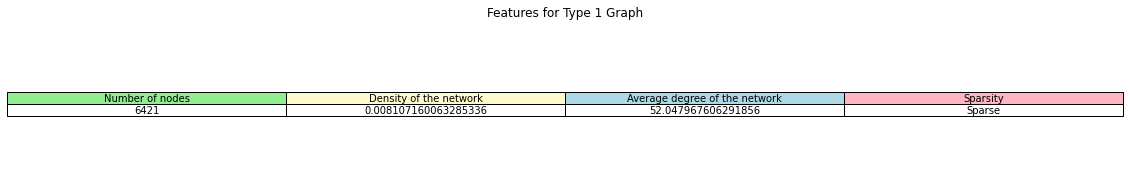

In [18]:
data = [[number_nodes, d, mean_deg, sparsity]]

plt.rcParams["figure.figsize"] = (20,3)
table = plt.table(cellText=data, colLabels=['Number of nodes', 'Density of the network', 'Average degree of the network', 'Sparsity'], loc='center', 
                  cellLoc='center', colColours=['#90EE90', '#FFFACD', '#ADD8E6', '#FFB6C1'])
table.auto_set_font_size(False)
h = table.get_celld()[(0,0)].get_height()
w = table.get_celld()[(0,0)].get_width()

plt.title('Features for Type 1 Graph')
plt.axis('off')
plt.show()

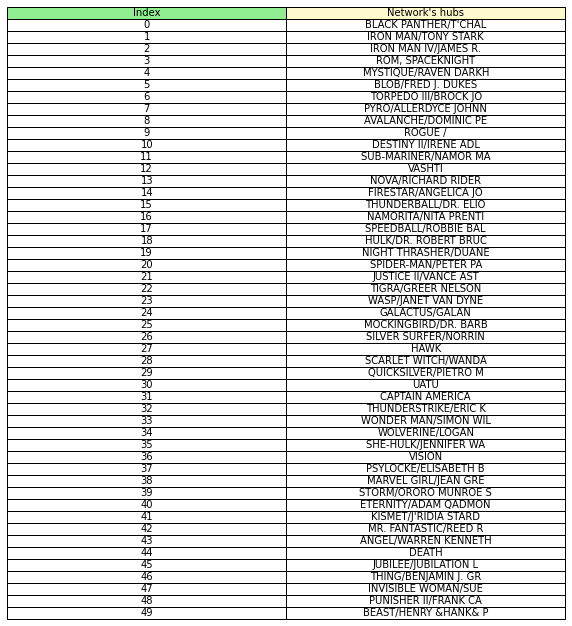

In [19]:
data= [[i,el] for i,el in zip(range(0,50), hubs[:50])]

plt.rcParams["figure.figsize"] = (10,4)
table = plt.table(cellText=data, colLabels=["Index", "Network's hubs"], loc='center', 
                  cellLoc='center', colColours=['#90EE90', '#FFFACD'])
table.auto_set_font_size(False)
h = table.get_celld()[(0,0)].get_height()
w = table.get_celld()[(0,0)].get_width()

#plt.title('Type1')
plt.axis('off')
plt.show()

In [20]:
d={ 'Name':co_list.keys(), 'Collaborations':co_list.values()}
df = pd.DataFrame(data=d)

In [21]:
df

Name  Collaborations
0            LITTLE, ABNER              22
1           PRINCESS ZANDA              11
2     BLACK PANTHER/T'CHAL             711
3     STEELE, SIMON/WOLFGA               9
4         FORTUNE, DOMINIC              15
...                    ...             ...
6416             BLACKWULF              11
6417        JILLETE, RANDI              10
6418       JENKINS, WALTER              10
6419   WAGNER, ERNIE WHACK              11
6420       DENNEHY, ROBERT              10

[6421 rows x 2 columns]

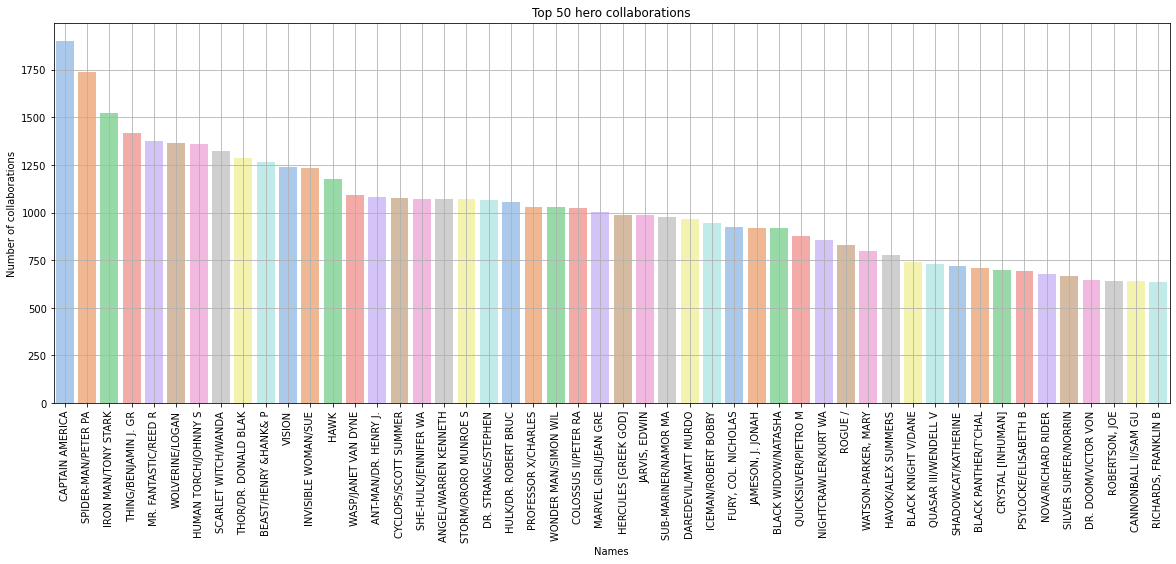

In [22]:
#Number of collaborations of each hero in descending order 
plt.rcParams['figure.figsize'] = [20,7]
plot_order = df.sort_values(by=['Collaborations'], ascending=False).head(50)
sns.barplot(data=plot_order, x="Name", y="Collaborations", palette="pastel").set(title='Top 50 hero collaborations')
plt.xlabel("Names")
plt.xticks(rotation=90)
plt.ylabel("Number of collaborations")
plt.grid()

Text(0.5, 1.0, 'Degree Distribution')

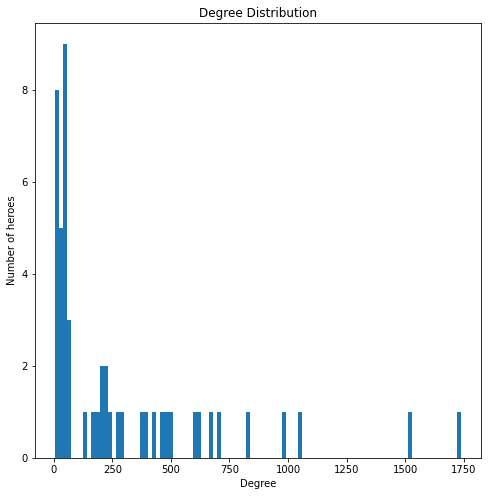

In [23]:
#To plot the degree distribution
plt.figure(figsize=(8,8))
plt.hist(deg_distro[:50], density=False, bins=100)
plt.ylabel('Number of heroes')
plt.xlabel('Degree')
plt.title('Degree Distribution')

#### If the graph is type 2

In [24]:
number_nodes, co_list, d, deg_distro, deg_distro_2, mean_deg, mean_deg_2, hubs, sparsity = Functionality_1(G_2, 2)

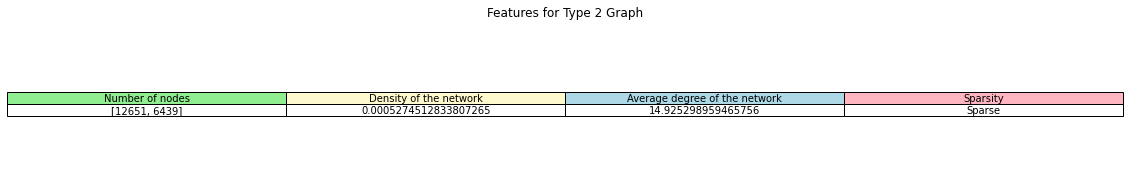

In [25]:
data = [[number_nodes, d, mean_deg_2, sparsity]]

plt.rcParams["figure.figsize"] = (20,3)
table = plt.table(cellText=data, colLabels=['Number of nodes', 'Density of the network', 'Average degree of the network', 'Sparsity'], loc='center', 
                  cellLoc='center', colColours=['#90EE90', '#FFFACD', '#ADD8E6', '#FFB6C1'])
table.auto_set_font_size(False)
h = table.get_celld()[(0,0)].get_height()
w = table.get_celld()[(0,0)].get_width()

plt.title('Features for Type 2 Graph')
plt.axis('off')
plt.show()

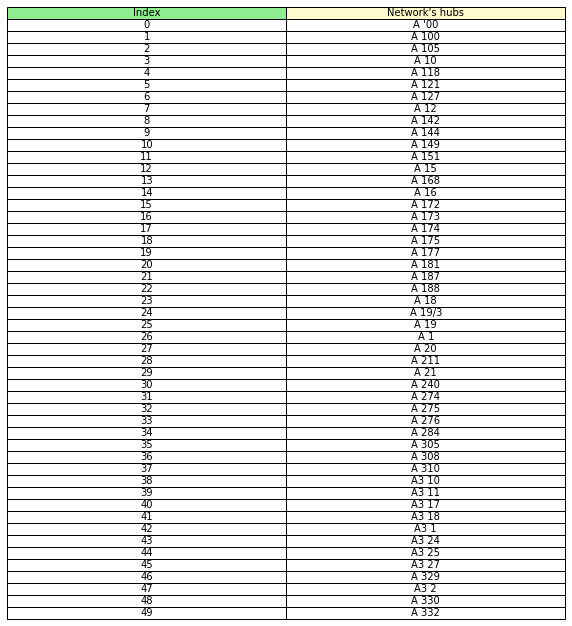

In [26]:
data= [[i,el] for i,el in zip(range(0,50), hubs[:50])]

plt.rcParams["figure.figsize"] = (10,4)
table = plt.table(cellText=data, colLabels=["Index", "Network's hubs"], loc='center', 
                  cellLoc='center', colColours=['#90EE90', '#FFFACD'])
table.auto_set_font_size(False)
h = table.get_celld()[(0,0)].get_height()
w = table.get_celld()[(0,0)].get_width()

plt.axis('off')
plt.show()

In [27]:
d2={ 'Comic Name':co_list.keys(), 'Number of heroes':co_list.values()}
df_2 = pd.DataFrame(data=d2)

In [28]:
df_2

Comic Name  Number of heroes
0           2001 10                 1
1            2001 8                 1
2            2001 9                 1
3             A '00                23
4             A '01                 9
...             ...               ...
12646  YOUNG MEN 24                 3
12647  YOUNG MEN 25                 1
12648  YOUNG MEN 26                 1
12649  YOUNG MEN 27                 1
12650  YOUNG MEN 28                 1

[12651 rows x 2 columns]

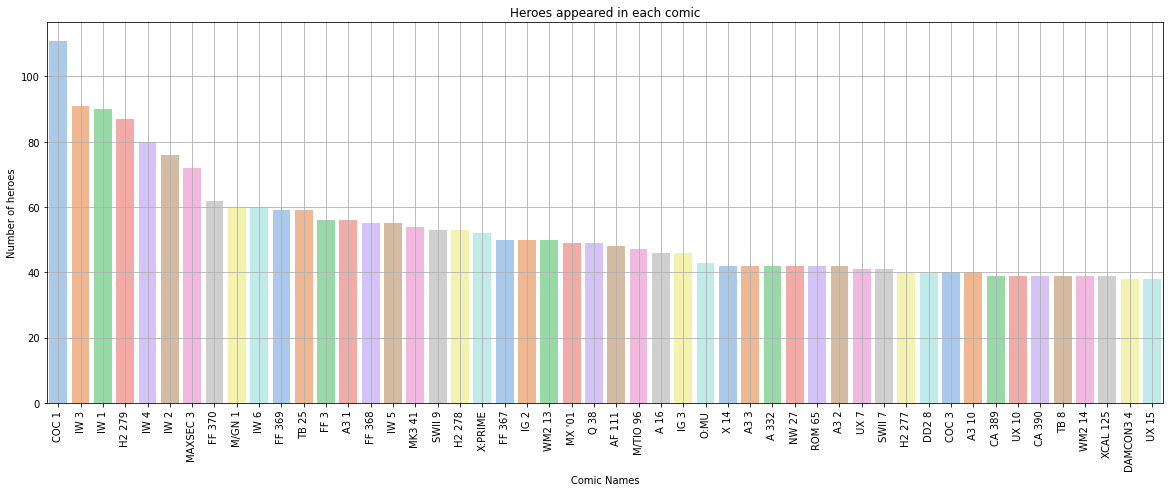

In [29]:
#Number of collaborations of each hero in descending order 
plt.rcParams['figure.figsize'] = [20,7]
plot_order = df_2.sort_values(by=['Number of heroes'], ascending=False).head(50)
sns.barplot(data=plot_order, x="Comic Name", y="Number of heroes", palette="pastel").set(title='Heroes appeared in each comic')
plt.xlabel("Comic Names")
plt.xticks(rotation=90)
plt.ylabel("Number of heroes")
plt.grid()

Text(0.5, 1.0, 'Degree Distribution')

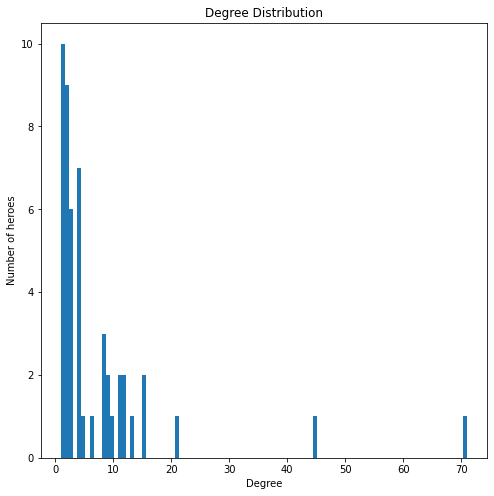

In [30]:
#To plot the degree distribution
plt.figure(figsize=(8,8))
plt.hist(deg_distro_2[:50], density=False, bins=100)
plt.ylabel('Number of heroes')
plt.xlabel('Degree')
plt.title('Degree Distribution')

### Visualization 2 - Visualize centrality measure

In this section, you will find

- A table containing the information related to the requested centrality measure for:
  - The average of the requested centrality measure for all of the network's nodes
  - The requested centrality measure's value for the given node

The requested metrics are:
- **1. -> Betweeness** : measures the centrality in a graph on the basis of shortest paths.
- **2 -> PageRank** : measures the importance of each node within the graph, on the basis of the number of incoming relationships and the importance of the corresponding source nodes.
- **3 -> Closeness Centrality** : (of a node) measures the centrality in a network, calculated as the reciprocal of the sum of the length of the shortest paths between the node and all other nodes in the graph.
- **4 -> Degree Centrality** :  (of a vertex of a graph) measures the number of edges incident to the vertex, with loops counted twice.

#### If the graph is type 1

In [31]:
#To create a subgraph of 50 heroes from G1
g1_sub = sub_g1(G_1, 50)

In [32]:
#We check if the chosen node is included in the subgraph
g1_sub.has_node("BLACK WIDOW/NATASHA")

True

In [33]:
output1, out_mean1 = Functionality_2(g1_sub, 1, "BLACK WIDOW/NATASHA", 1)
output2, out_mean2 = Functionality_2(g1_sub, 1, "BLACK WIDOW/NATASHA", 2)
output3, out_mean3 = Functionality_2(g1_sub, 1, "BLACK WIDOW/NATASHA", 3)
output4, out_mean4 = Functionality_2(g1_sub, 1, "BLACK WIDOW/NATASHA", 4)

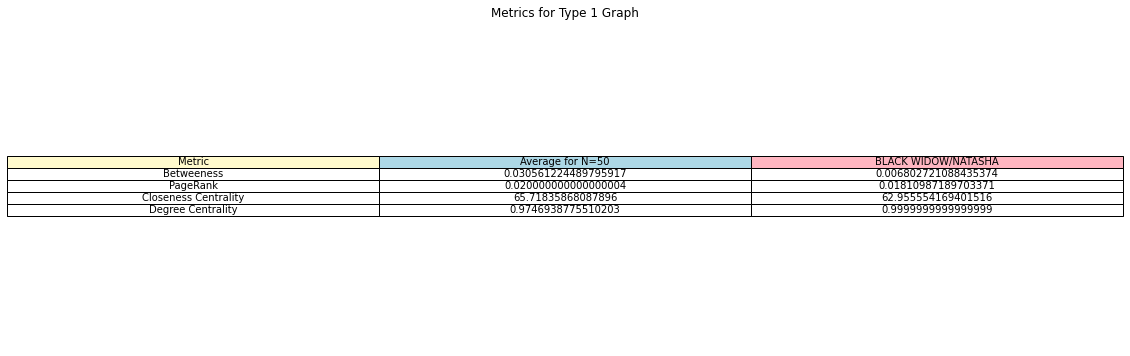

In [34]:
data = [["Betweeness", out_mean1, output1], ["PageRank", out_mean2, output2], ["Closeness Centrality", out_mean3, output3], ["Degree Centrality", out_mean4, output4]]

plt.rcParams["figure.figsize"] = (20,6)
table = plt.table(cellText=data, colLabels=['Metric', 'Average for N=50', 'BLACK WIDOW/NATASHA'], loc='center', 
                  cellLoc='center', colColours=['#FFFACD', '#ADD8E6', '#FFB6C1'])
table.auto_set_font_size(False)
h = table.get_celld()[(0,0)].get_height()
w = table.get_celld()[(0,0)].get_width()

plt.title('Metrics for Type 1 Graph')
plt.axis('off')
plt.show()

As we can see from the table above, the chosen node has the various metrics in line with the average values, with the exception of Betweenness Centrality which is considerably lower. This means that the node has a low amount of influence over the flow of information in the graph.

#### If the graph is type 2

In [35]:
#To create a subgraph of 50 heroes from G2
g2_sub = sub_g2(G_2, 50)

In [36]:
#We check if the chosen node is included in the subgraph
g2_sub.has_node("BLACK WIDOW/NATASHA")

True

In [37]:
output1, out_mean1 = Functionality_2(g2_sub, 2, "BLACK WIDOW/NATASHA", 1)
output2, out_mean2 = Functionality_2(g2_sub, 2, "BLACK WIDOW/NATASHA", 2)
output3, out_mean3 = Functionality_2(g2_sub, 2, "BLACK WIDOW/NATASHA", 3)
output4, out_mean4 = Functionality_2(g2_sub, 2, "BLACK WIDOW/NATASHA", 4)

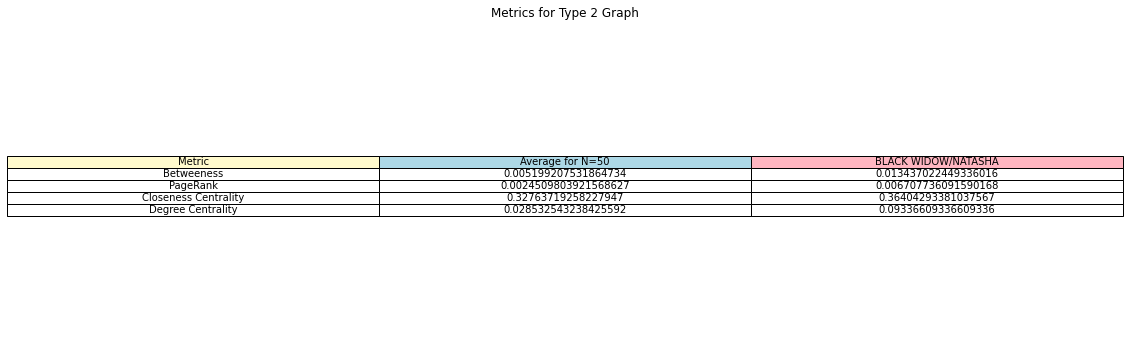

In [38]:
data = [["Betweeness", out_mean1, output1], ["PageRank", out_mean2, output2], ["Closeness Centrality", out_mean3, output3], ["Degree Centrality", out_mean4, output4]]

plt.rcParams["figure.figsize"] = (20,6)
table = plt.table(cellText=data, colLabels=['Metric', 'Average for N=50', 'BLACK WIDOW/NATASHA'], loc='center', 
                  cellLoc='center', colColours=['#FFFACD', '#ADD8E6', '#FFB6C1'])
table.auto_set_font_size(False)
h = table.get_celld()[(0,0)].get_height()
w = table.get_celld()[(0,0)].get_width()

plt.title('Metrics for Type 2 Graph')
plt.axis('off')
plt.show()

As we can see from the table above, the chosen node has Closeness Centrality in line with the average value. For what it concerns Betweenness Centrality the value is much higher than the average, this means that the node has a high amount of influence over the flow of information in the graph and serves as a bridge from one part of the graph to another. PageRank metric is a little bit higher than the average value, meaning that the node is important within the graph, on the basis of the number of incoming relationships. 

### Visualization 3 - Visualize the shortest-ordered route

In this section you will find:
- The comics in the shortest walk in order
- A plot of the graph and the identification of the nodes and edges that appear in the shortest walk (identifier on each edge in the shortest walk to determine the order that we should have the walk)

In [37]:
#To create a subgraph of 8 heroes from G2
g2_sub2 = sub_g2(G_2, 8)

In [38]:
list(g2_sub2.nodes.data())

[('A 11', {'kind': 'comic'}),
 ('MR. FANTASTIC/REED R', {'kind': 'hero'}),
 ('IRON MAN/TONY STARK', {'kind': 'hero'}),
 ('CAPTAIN AMERICA', {'kind': 'hero'}),
 ('THING/BENJAMIN J. GR', {'kind': 'hero'}),
 ("A '00", {'kind': 'comic'}),
 ('A 1', {'kind': 'comic'}),
 ('A 118', {'kind': 'comic'}),
 ('A 10', {'kind': 'comic'}),
 ('HUMAN TORCH/JOHNNY S', {'kind': 'hero'}),
 ('THOR/DR. DONALD BLAK', {'kind': 'hero'}),
 ('SPIDER-MAN/PETER PA', {'kind': 'hero'}),
 ('A 100', {'kind': 'comic'}),
 ('HULK/DR. ROBERT BRUC', {'kind': 'hero'})]

In [39]:
h = ['IRON MAN/TONY STARK', 'SPIDER-MAN/PETER PA' ]
h_1 =  ['HUMAN TORCH/JOHNNY S']
h_n = ['HULK/DR. ROBERT BRUC']

In [40]:
comic_walk = Functionality_3(g2_sub2, h, h_1, h_n)

In [41]:
comic_walk

['A 1', 'A 11', 'A 118']

{('HUMAN TORCH/JOHNNY S',
  'A 1'): Text(0.5268090852926578, 0.09385379931908938, '1'),
 ('A 1',
  'IRON MAN/TONY STARK'): Text(-0.05833766687767955, 0.12271850909851352, '2'),
 ('IRON MAN/TONY STARK',
  'A 11'): Text(-0.2426181116974471, -0.30716222852314823, '3'),
 ('A 11',
  'SPIDER-MAN/PETER PA'): Text(0.12857939854354347, -0.6702923405168297, '4'),
 ('SPIDER-MAN/PETER PA',
  'A 118'): Text(0.34153926601242746, -0.3549805843855275, '5'),
 ('A 118',
  'HULK/DR. ROBERT BRUC'): Text(0.13677951414358044, 0.32427173369936346, '6')}

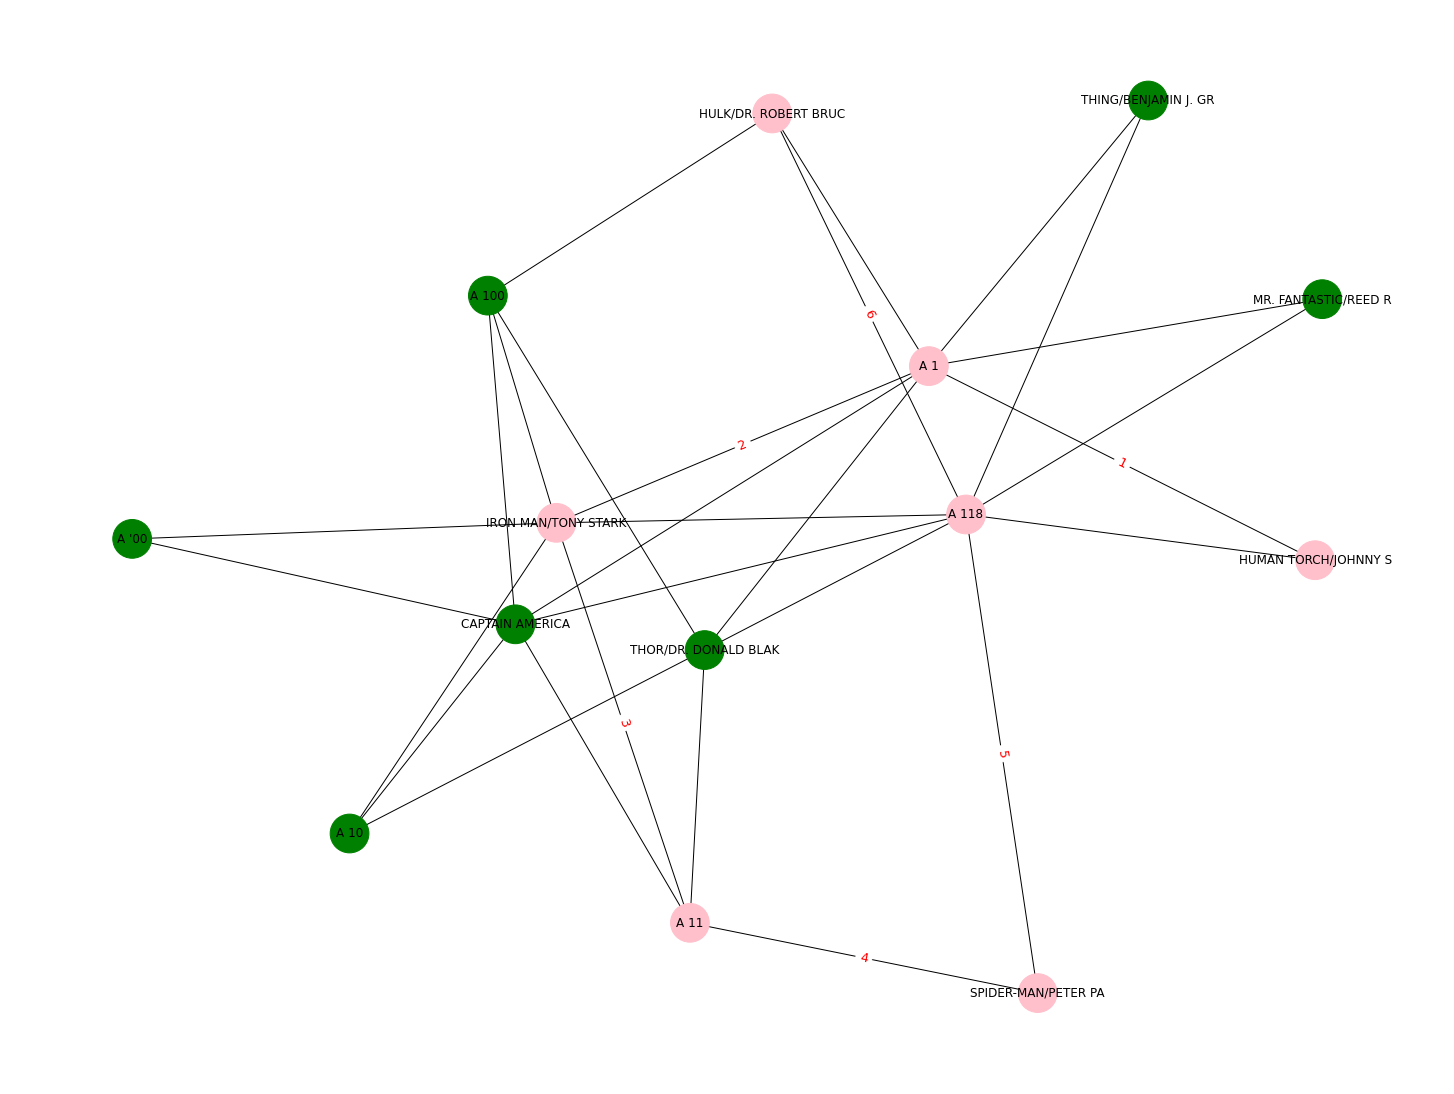

In [58]:
#To plot our graph
color = []
h_all = h_1 + h + h_n
edge_l = {('HUMAN TORCH/JOHNNY S', 'A 1'):'1', ('A 1', 'IRON MAN/TONY STARK'):'2', ('IRON MAN/TONY STARK', 'A 11'):'3', ('A 11', 'SPIDER-MAN/PETER PA' ):'4', ('SPIDER-MAN/PETER PA', 'A 118'): '5', ('A 118', 'HULK/DR. ROBERT BRUC'): '6'}
pos = nx.spring_layout(g2_sub2)

for node in g2_sub2:
    if node in h_all or node in comic_walk:
        color.append("pink")
    else:
        color.append("green")
        
plt.figure(3, figsize=(20, 15)) 
nx.draw(g2_sub2, pos, node_color = color, with_labels = True, node_size = 1500 )
nx.draw_networkx_edge_labels(g2_sub2, pos, edge_labels = edge_l, font_size = 13, font_color = "red")

### Visualization 4 - Visualize the disconnected graph

In this section you will find:
- The number of the links that should be disconnected
- Plot of the original graph
- Plot of the graph after removing the links and identification of the two nodes

Since Functionality_4 is based on Karger's Algorithm, which has a randomic nature, we tried a spectrum of iteration numbers: first a single run (which should result in a random cut), then increasing the  number of iterations to 100 on G1 and 1000 on G2.

#### 1 Iteration

The number of links to disconnects is:  24


Text(0.5, 1.0, 'Original Graph')

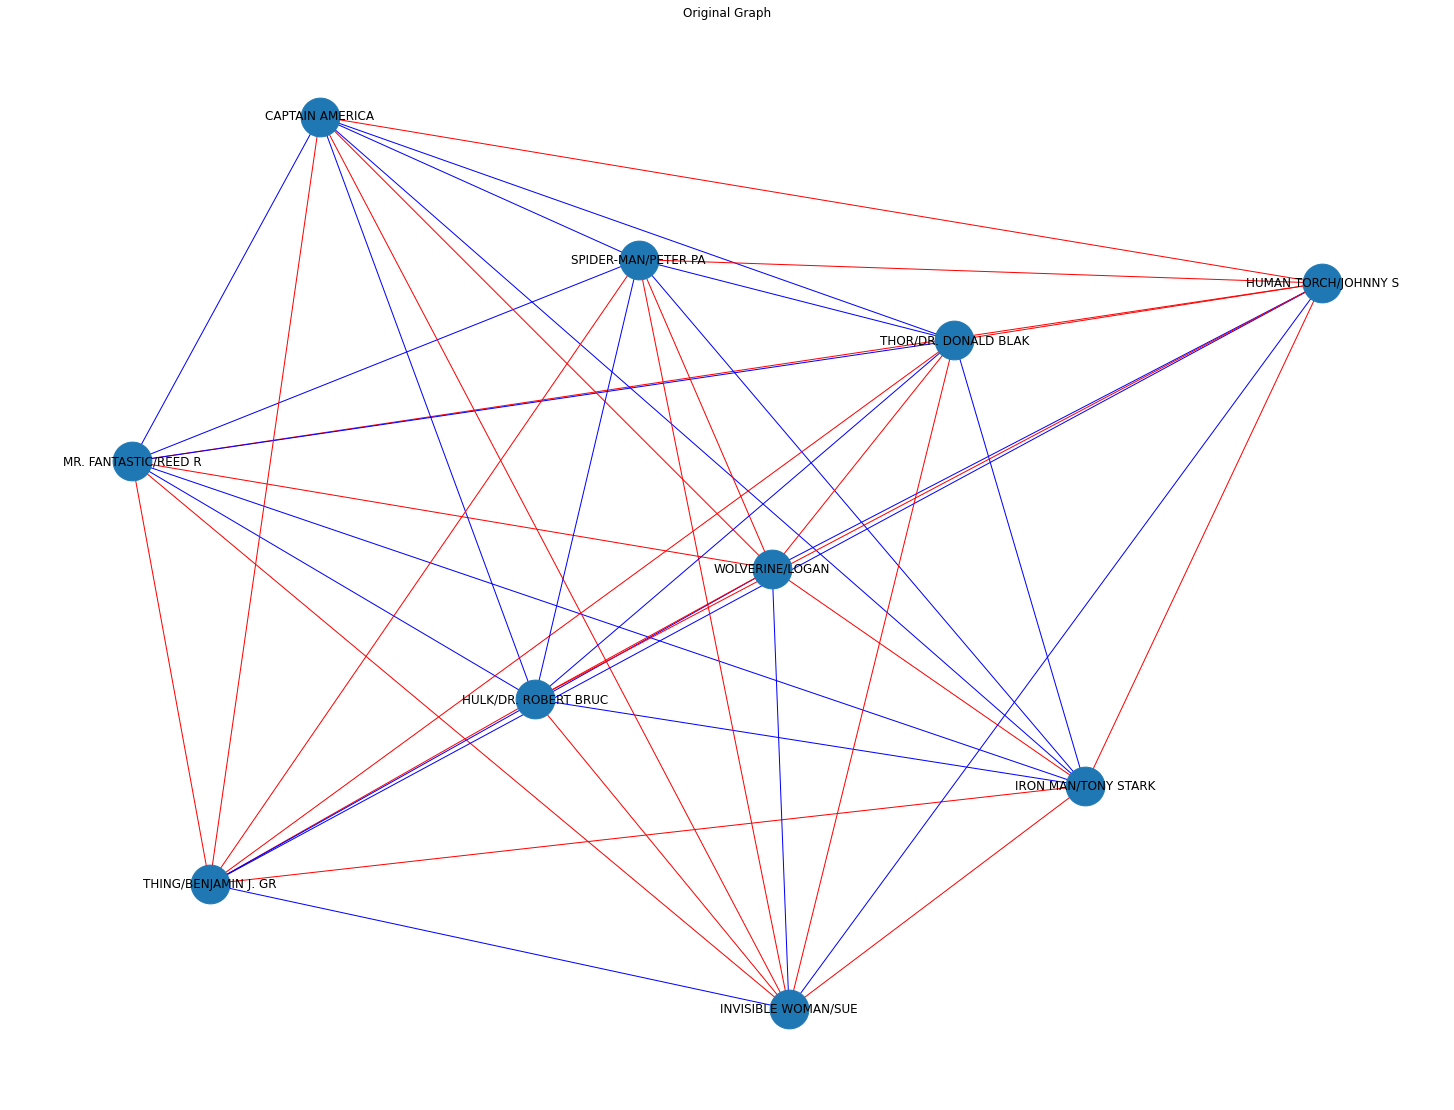

In [188]:
#To create a subgraph of 10 heroes from G1
g1_sub2 = sub_g1(G_1, 10)

G_red1 = Functionality_4(g1_sub2, 1, 'WOLVERINE/LOGAN', 'HULK/DR. ROBERT BRUC', 1)

#Number of the links that should be disconnected
number_links = len(G_red1.edges())
print("The number of links to disconnects is: ", number_links)

lista_1 = [k for i,j,k in G_red1.edges(data = 'label')]

lista_2 = []
for i in lista_1:
    temp = i.split(" | ")
    lista_2.append((temp[0],temp[1]))

#Plot of the original graph wherre in red we identified the edges to disconnect
color=[]
pos = nx.spring_layout(g1_sub2)

lista_2_rev = [t[::-1] for t in lista_2]
for i in g1_sub2.edges():
    if (i in lista_2) | (i in lista_2_rev):
        color.append("red")
    else: color.append("blue")
color

plt.figure(3, figsize=(20, 15)) 
nx.draw(g1_sub2, pos, edge_color = color, with_labels = True, node_size = 1500 )
plt.title('Original Graph')

Text(0.5, 1.0, 'Disconnected Graph')

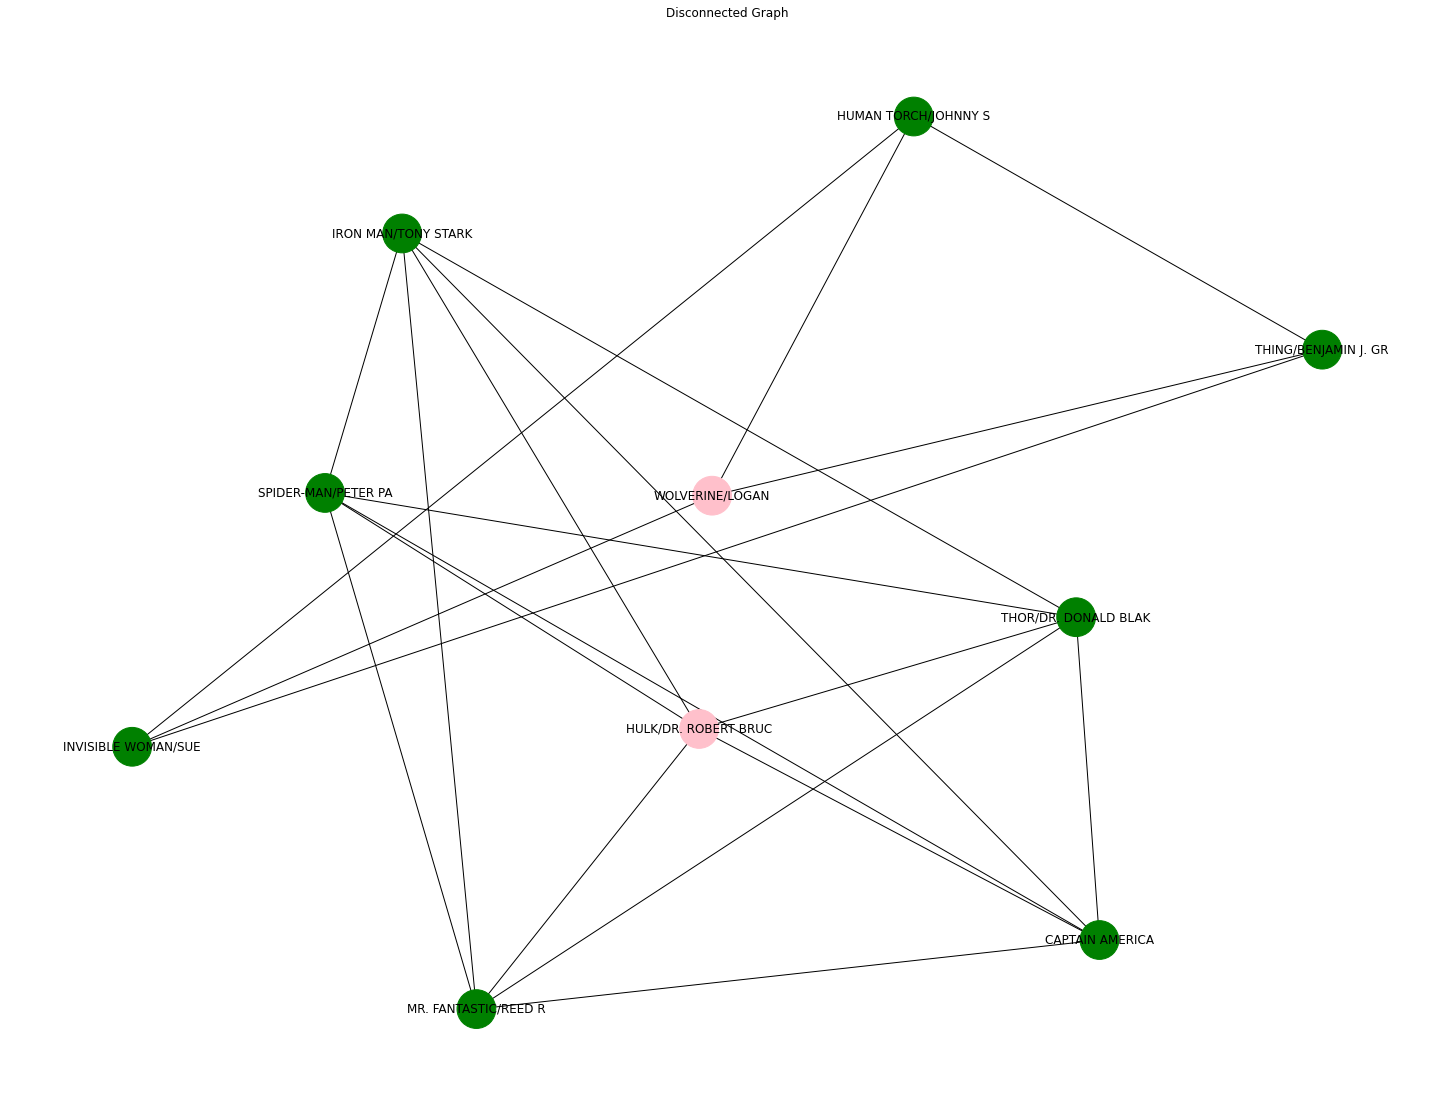

In [192]:
#Plot of the graph after removing the links and identification of the two nodes
nodes1 = list(g1_sub2.nodes())

g1_sub2_copy = g1_sub2.copy()
for i in lista_2:
    g1_sub2_copy.remove_edge(*i)

color=[]
pos = nx.spring_layout(g1_sub2)

for node in g1_sub2.nodes():
    if node in ['WOLVERINE/LOGAN', 'HULK/DR. ROBERT BRUC']:
        color.append("pink")
    else:
        color.append("green")
        
plt.figure(3, figsize=(20, 15)) 
nx.draw(g1_sub2_copy, pos, node_color = color, with_labels = True, node_size = 1500 )
plt.title('Disconnected Graph')

#### 100 Iterations on G1

The number of links to disconnects is:  9


Text(0.5, 1.0, 'Original Graph')

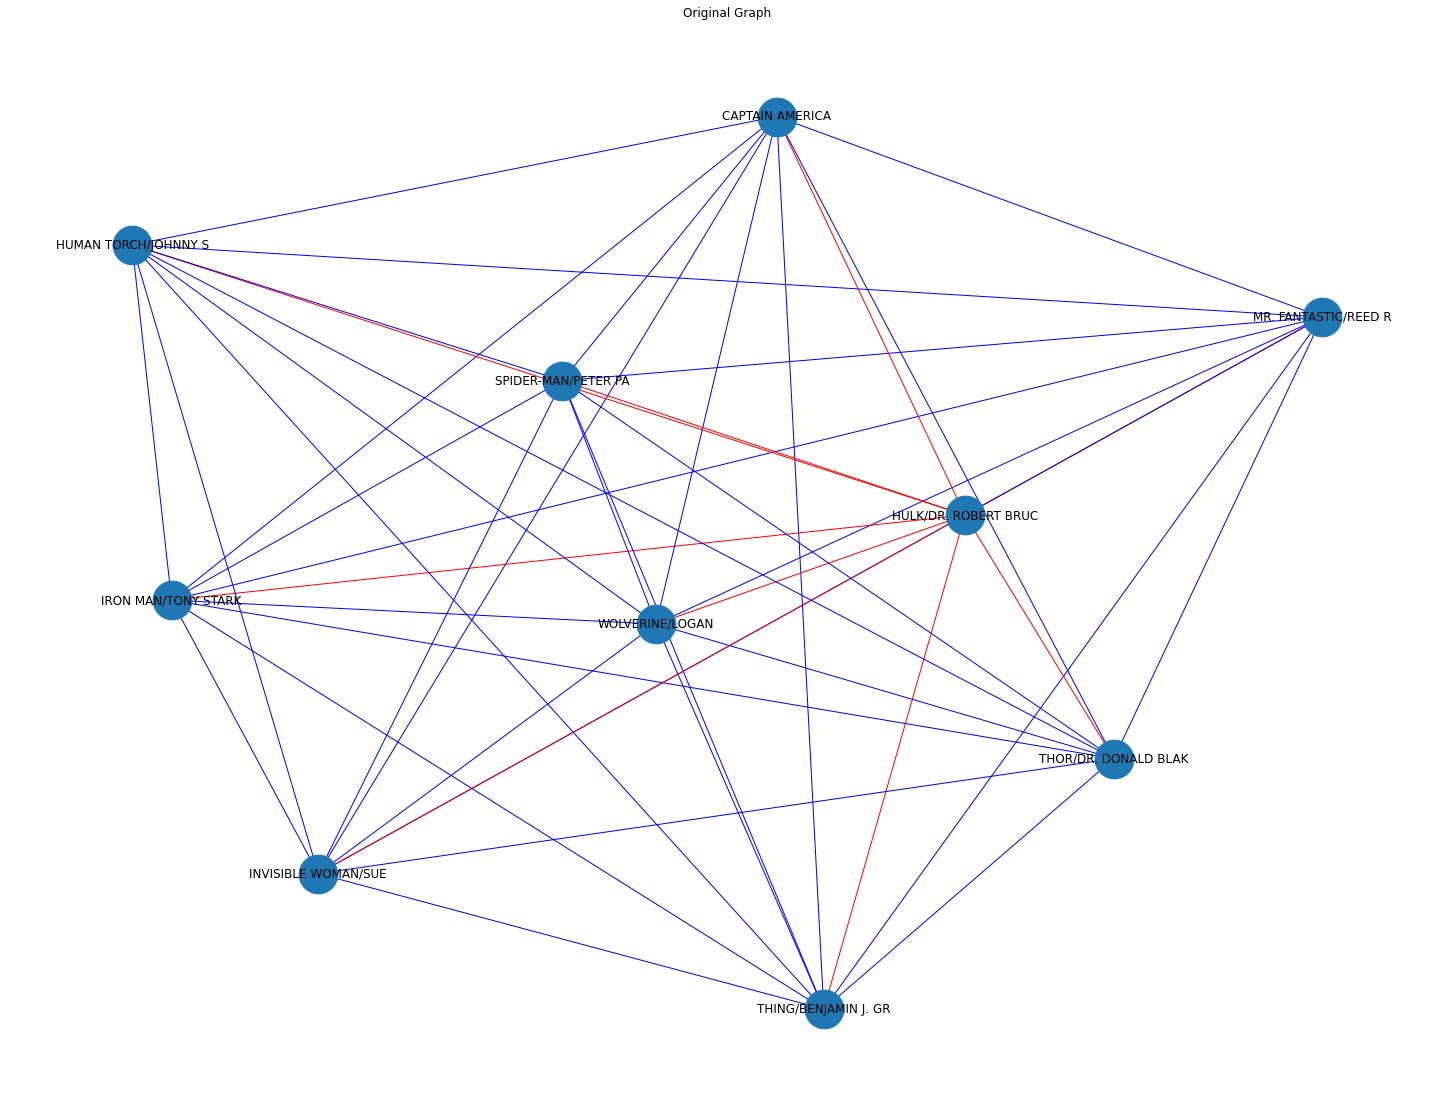

In [193]:
#To create a subgraph of 10 heroes from G1
g1_sub2 = sub_g1(G_1, 10)

G_red1 = Functionality_4(g1_sub2, 1, 'WOLVERINE/LOGAN', 'HULK/DR. ROBERT BRUC', 100)

#Number of the links that should be disconnected
number_links = len(G_red1.edges())
print("The number of links to disconnects is: ", number_links)

lista_1 = [k for i,j,k in G_red1.edges(data = 'label')]

lista_2 = []
for i in lista_1:
    temp = i.split(" | ")
    lista_2.append((temp[0],temp[1]))

#Plot of the original graph wherre in red we identified the edges to disconnect
color=[]
pos = nx.spring_layout(g1_sub2)

lista_2_rev = [t[::-1] for t in lista_2]
for i in g1_sub2.edges():
    if (i in lista_2) | (i in lista_2_rev):
        color.append("red")
    else: color.append("blue")
color

plt.figure(3, figsize=(20, 15)) 
nx.draw(g1_sub2, pos, edge_color = color, with_labels = True, node_size = 1500 )
plt.title('Original Graph')

Text(0.5, 1.0, 'Disconnected Graph')

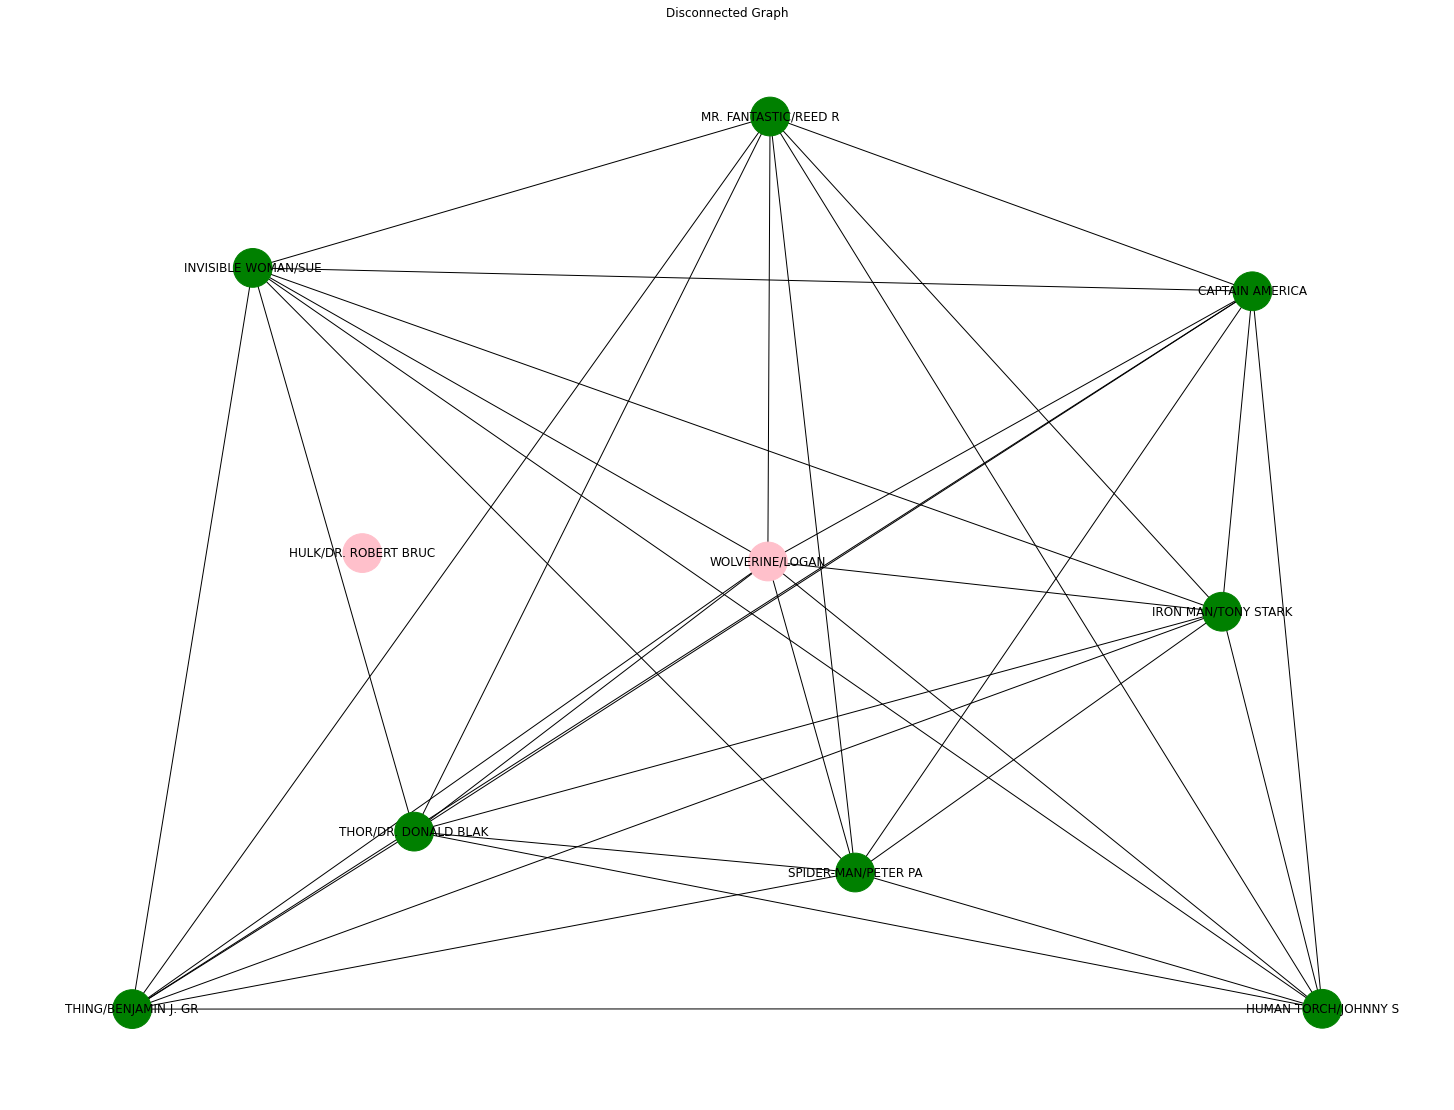

In [194]:
#Plot of the graph after removing the links and identification of the two nodes
nodes1 = list(g1_sub2.nodes())

g1_sub2_copy = g1_sub2.copy()
for i in lista_2:
    g1_sub2_copy.remove_edge(*i)

color=[]
pos = nx.spring_layout(g1_sub2)

for node in g1_sub2.nodes():
    if node in ['WOLVERINE/LOGAN', 'HULK/DR. ROBERT BRUC']:
        color.append("pink")
    else:
        color.append("green")
        
plt.figure(3, figsize=(20, 15)) 
nx.draw(g1_sub2_copy, pos, node_color = color, with_labels = True, node_size = 1500 )
plt.title('Disconnected Graph')

Given the nature of the graph, after a large numer of iterations, the minimum cut turns out to be the complete disconnection of one of the two nodes of interest from the rest of the graph. Above, in the 1 iteration section, we showed an example of a random cut performed by the algorithm.

#### 1000 Iterations on G2

The number of links to disconnects is:  10


Text(0.5, 1.0, 'Original Graph')

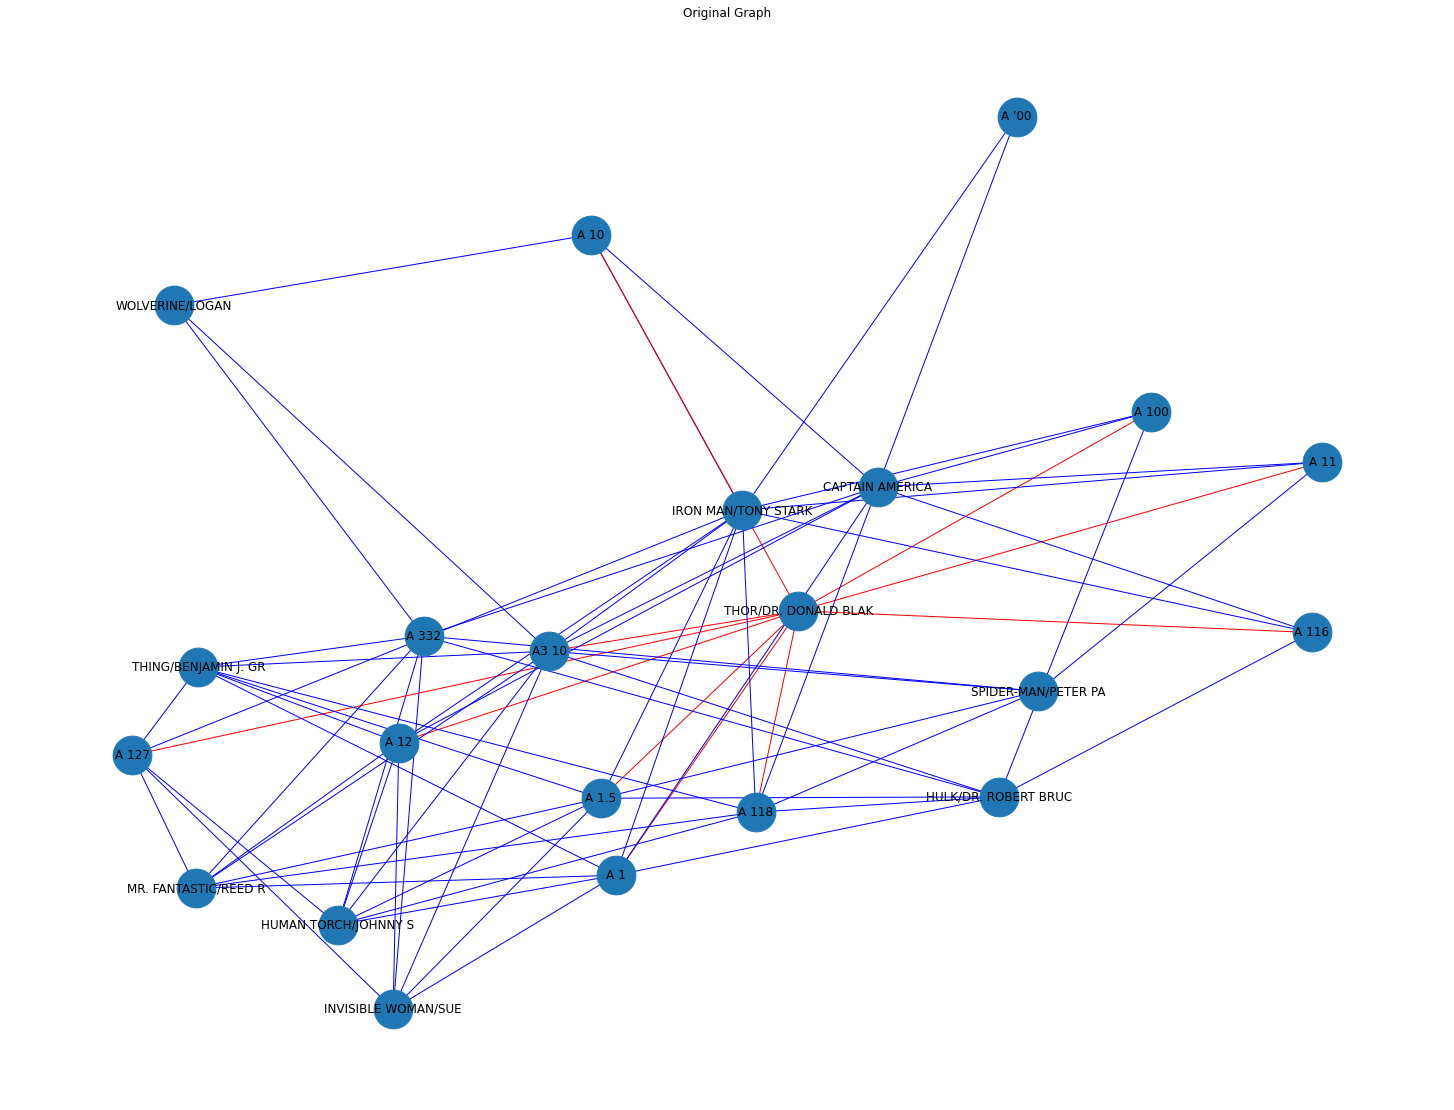

In [204]:
#To create a subgraph of 10 heroes from G2
g2_sub2 = sub_g2(G_2, 10)

G_red = Functionality_4(g2_sub2, 2, 'THOR/DR. DONALD BLAK', 'IRON MAN/TONY STARK', 1000)

#Number of the links that should be disconnected
number_links = len(G_red.edges())
print("The number of links to disconnects is: ", number_links)

lista = [k for i,j,k in G_red.edges(data = 'label')]

lista2 = []
for i in lista:
    temp = i.split(" | ")
    lista2.append((temp[0],temp[1]))

#Plot of the original graph wherre in red we identified the edges to disconnect
color=[]
pos = nx.spring_layout(g2_sub2)

lista2_rev = [t[::-1] for t in lista2]
for i in g2_sub2.edges():
    if (i in lista2) | (i in lista2_rev):
        color.append("red")
    else: color.append("blue")
color

plt.figure(3, figsize=(20, 15)) 
nx.draw(g2_sub2, pos, edge_color = color, with_labels = True, node_size = 1500 )
plt.title('Original Graph')

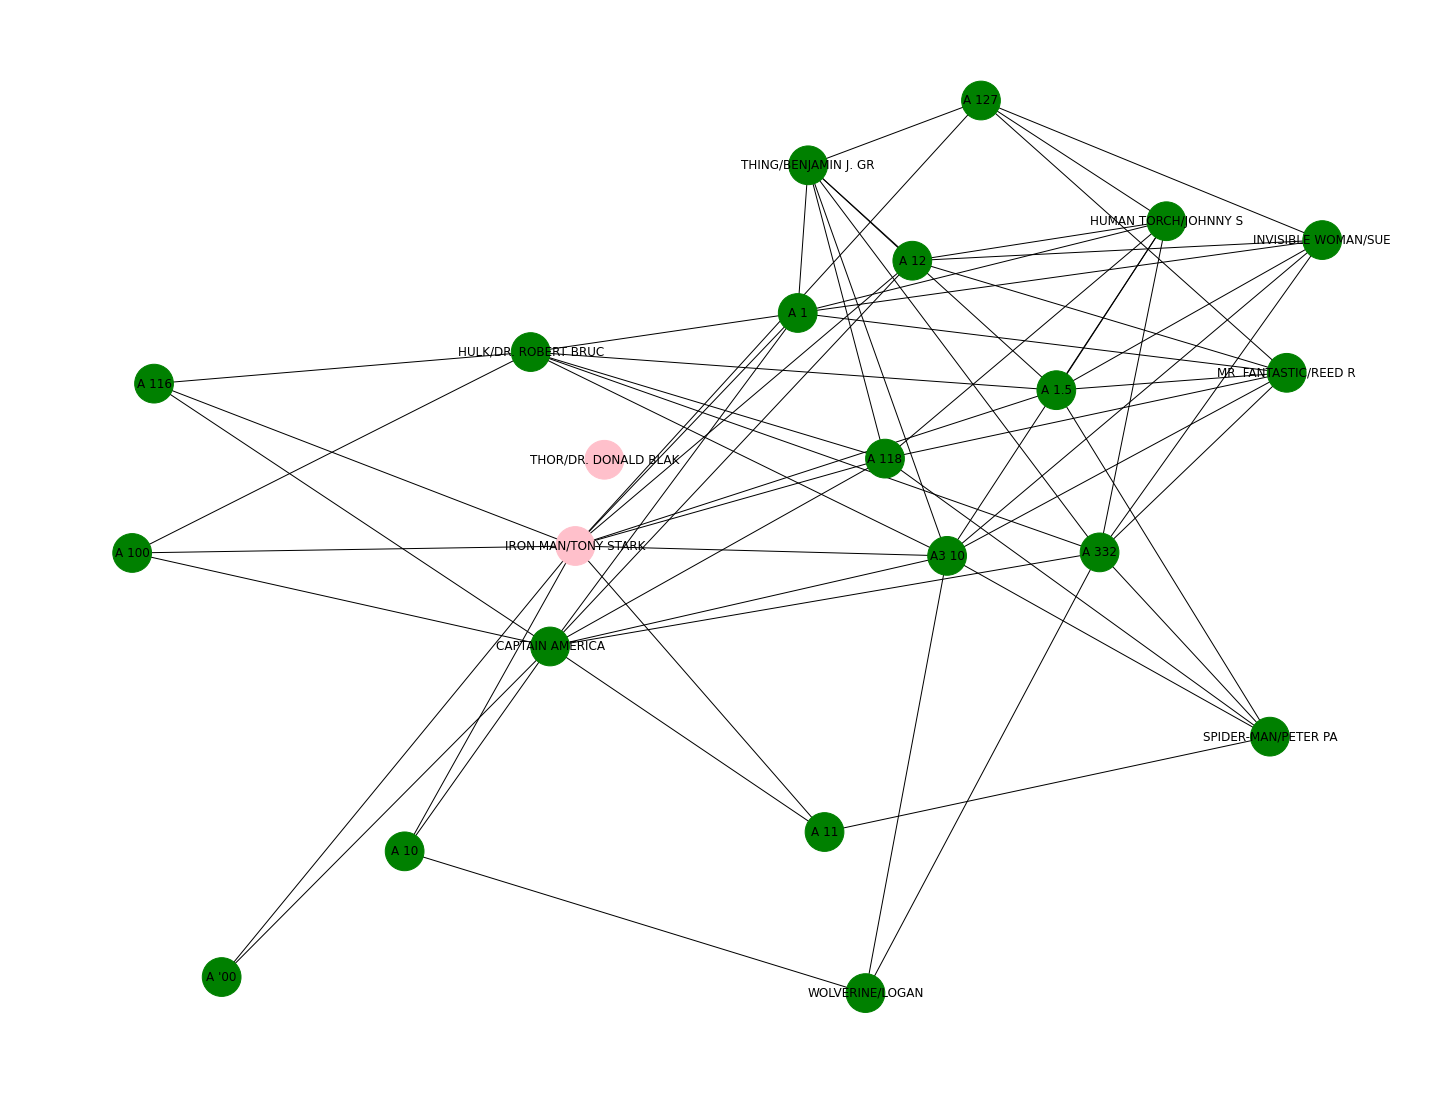

In [208]:
#Plot of the graph after removing the links and identification of the two nodes
nodes = list(g2_sub2.nodes())

g2_sub2_copy = g2_sub2.copy()
for i in lista2:
    g2_sub2_copy.remove_edge(*i)

color=[]
pos = nx.spring_layout(g2_sub2)

for node in g2_sub2.nodes():
    if node in ['THOR/DR. DONALD BLAK', 'IRON MAN/TONY STARK']:
        color.append("pink")
    else:
        color.append("green")
        
plt.figure(3, figsize=(20, 15)) 
nx.draw(g2_sub2_copy, pos, node_color = color, with_labels = True, node_size = 1500 )
plt.title('Disconnected Graph')

Regarding the performance of the algorithm on G2, we observed the same behaviour stated in the 100 iterations on G1 section, also increasing the number of iterations to 1000.

### Visualization 5 - Visualize the communities

In this section you will find:
- The number of links that should be removed to have the communities
- A table depicting the communities and the heroes that belong to each community
- Plot of the original graph
- Plot of the graph showing the communities in the network
- Plot of the final graph and identification of the community/communities of Hero_1 and Hero_2

In [215]:
#To print the number of links that should be removed to have the communities
num_link,nodes_g,components= Functionality_5(G_1, 20, 'SUB-MARINER/NAMOR MA', 'MR. FANTASTIC/REED R')
num_link

19

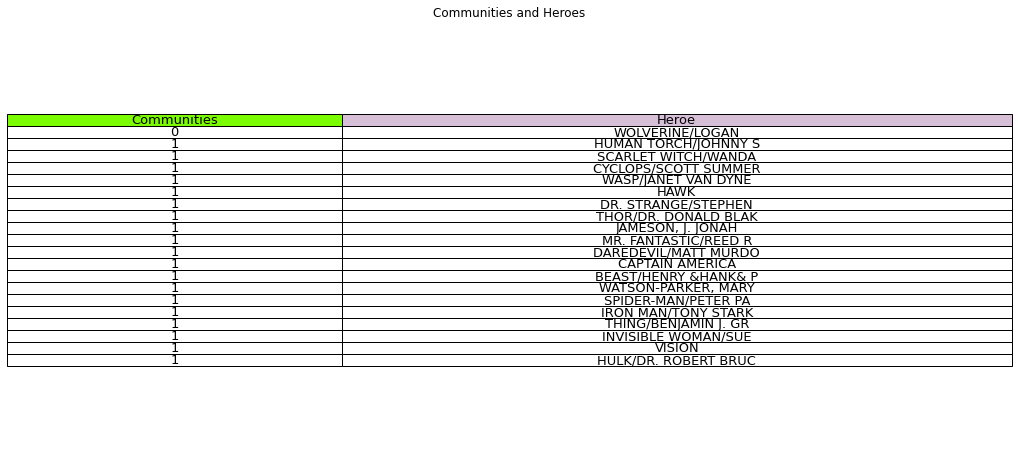

In [216]:
#To plot a table depicting the communities and the heroes that belong to each community
data=[]
for i in range(len(nodes_g)):
    for el in nodes_g[i]:
        data.append([i,el])
    
plt.rcParams["figure.figsize"] = (18,8)
table = plt.table(cellText=data, colWidths=[1/3,2/3], colLabels=['Communities', 'Heroe'], loc='center', 
                  cellLoc='center', colColours=['lawngreen', 'thistle'])
table.auto_set_font_size(False)
table.set_fontsize(13)

plt.title('Communities and Heroes')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Original Graph')

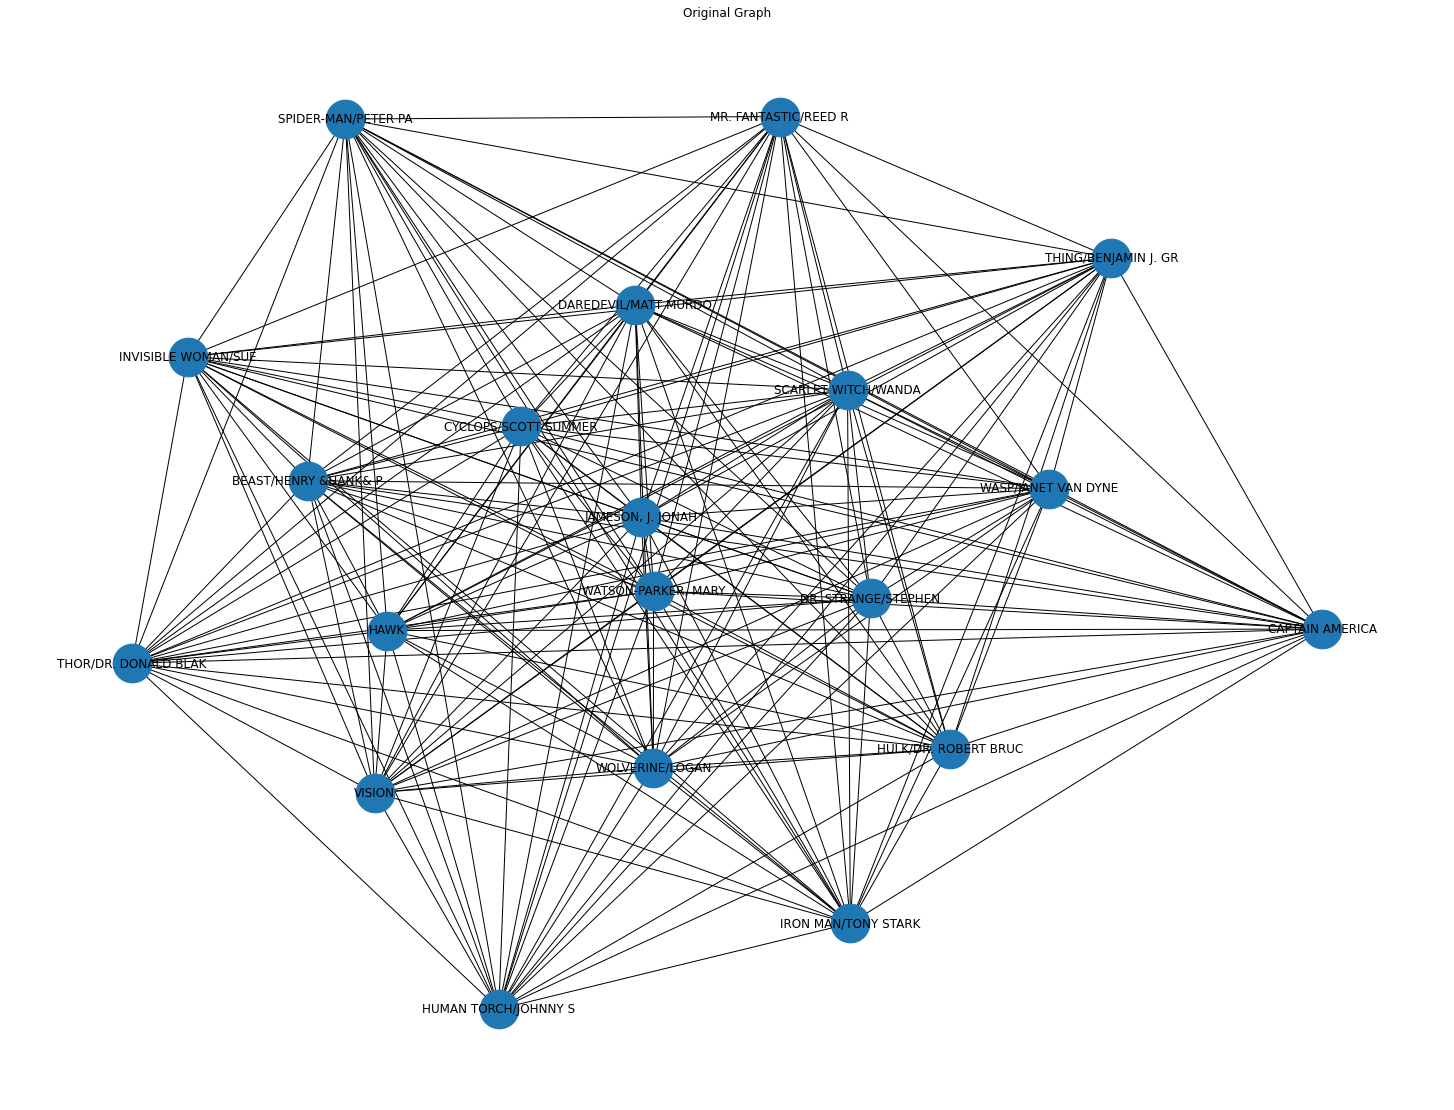

In [217]:
#To plot the original graph
G1_sub= sub_g1(G_1,20)
plt.figure(3, figsize=(20, 15)) 
nx.draw(G1_sub,with_labels=True,node_size = 1500)
plt.title('Original Graph')

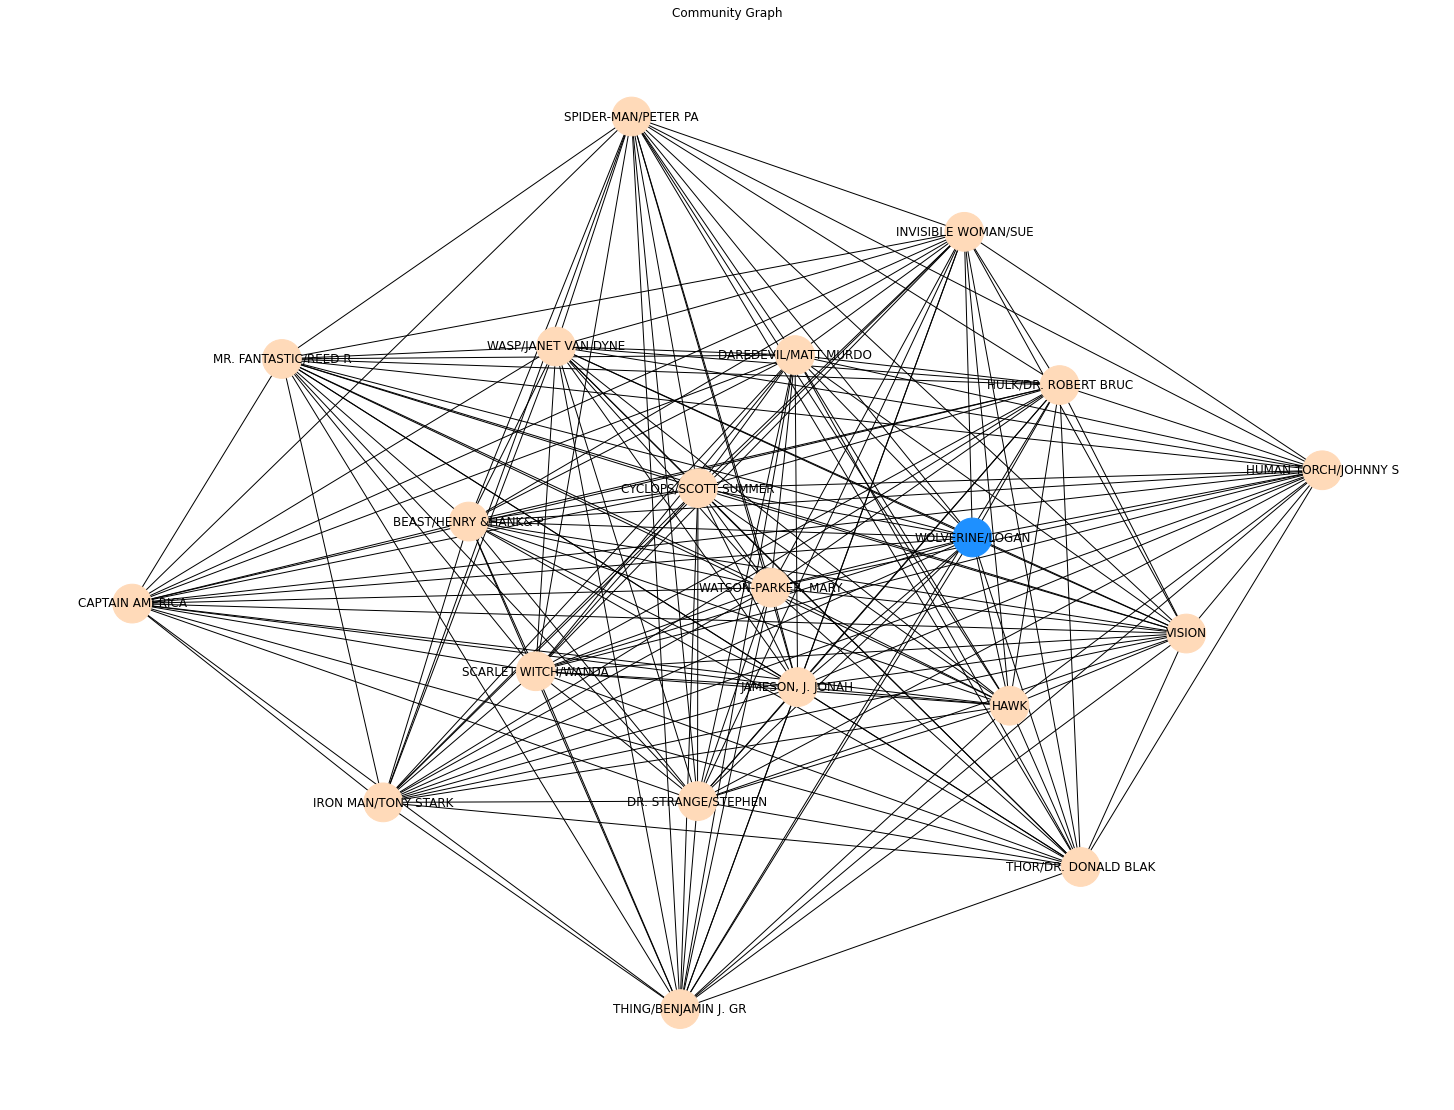

In [236]:
# To plot the graph showing the communities in the network
color_map = []
for node in G1_sub:
    if node in nodes_g[0]:
        color_map.append('dodgerblue')
    else: 
        color_map.append('peachpuff')  

plt.figure(3, figsize=(20, 15)) 
nx.draw(G1_sub, node_color=color_map, with_labels=True,node_size = 1500)
plt.title('Community Graph')
plt.show()

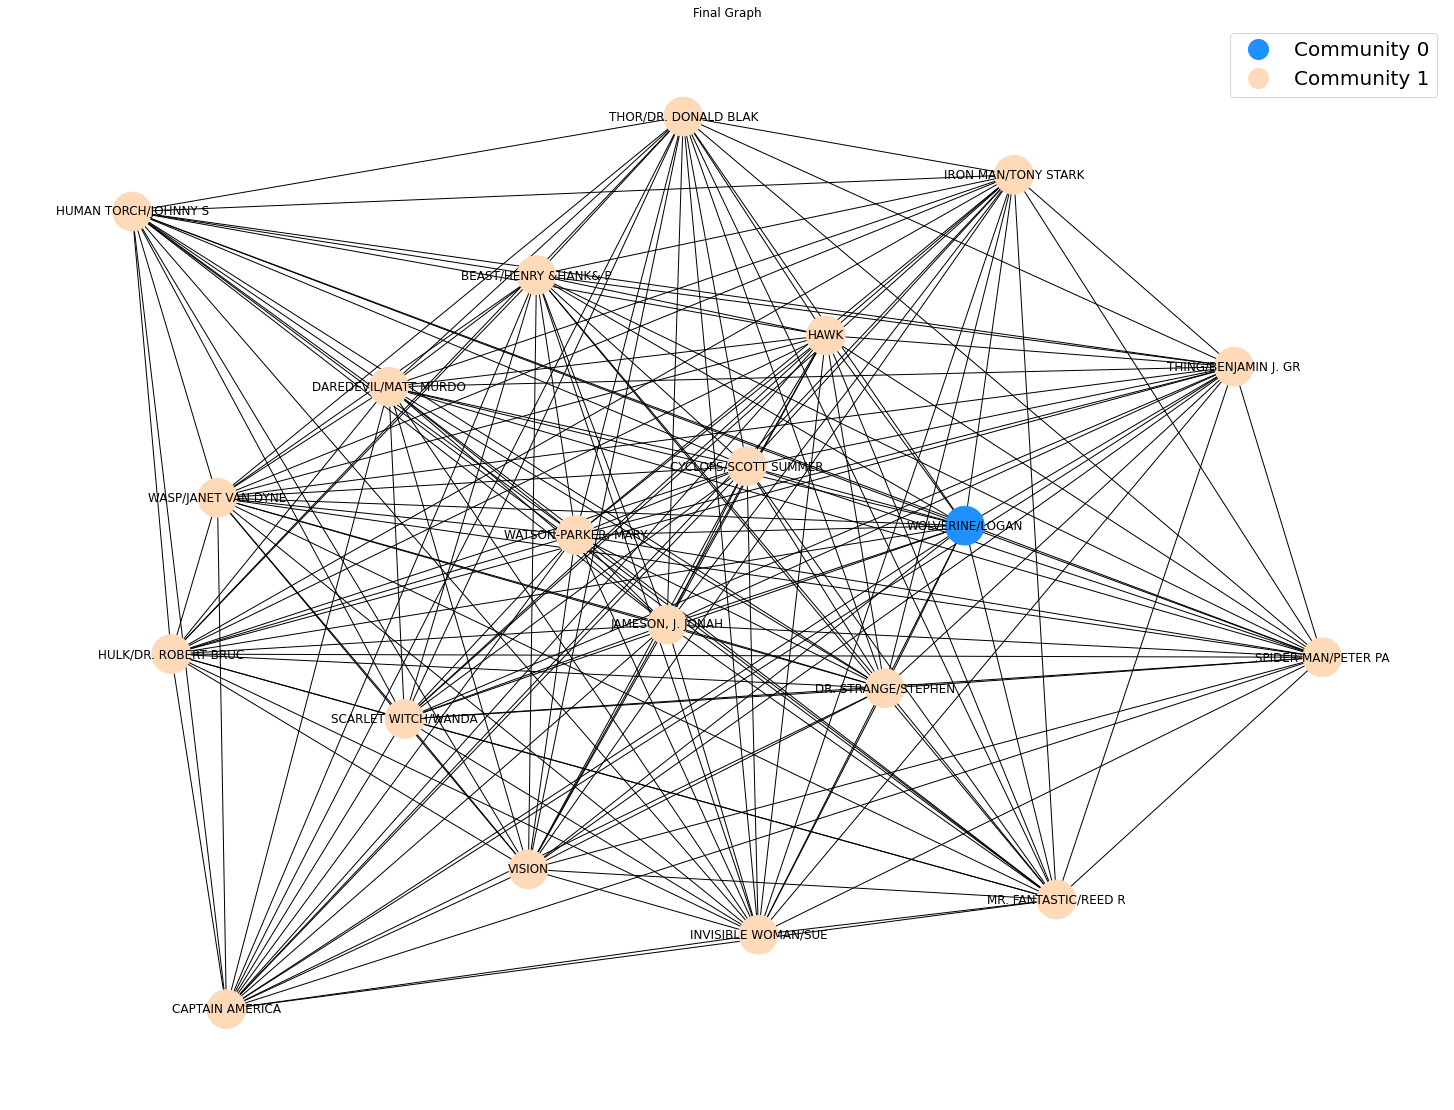

In [237]:
#To plot the final graph identifying the community/communities of Hero_1 and Hero_2
plt.figure(3, figsize=(20, 15)) 
nx.draw(G1_sub, node_color=color_map, with_labels=True,node_size = 1500)

Community_0 = mlines.Line2D([], [], color='dodgerblue', marker='o', linestyle='None',
                          markersize=20, label='Community 0')
Community_1 = mlines.Line2D([], [], color='peachpuff', marker='o', linestyle='None',
                          markersize=20, label='Community 1')

plt.legend(handles=[Community_0,Community_1],fontsize=20)
plt.title('Final Graph')
plt.show()

# 6. Algorithmic Question
The idea behind this algorithm is to convert each position in the 3x3 grid to a tuple of integers, converting the four possible directions to an addition or subtraction by one from the left or right values inside the tuple, we can update the position step by step. In order to consider the possibility of doubling distances at each step I created a list of commands right after the input, that take into account all possible combinations of single and double distances. At the end the self intersecting paths and those that go out of bounds are not considered.

In [232]:
def commands(x):
    if x == "R": return(1,0)
    elif x == "L": return(-1,0)
    elif x == "U": return(0,1)
    elif x == "D": return(0,-1)

In [233]:
com = list(input())
everytrack = [com]

for h in range(1, len(com)+1):
    b = list(combinations(range(len(com)),h))   # Here a list of all possible paths, including all the combinations of 
    for i in b:                                 # double distances, is created
        z=[]    
        for j in range(len(com)):
            if j in i: 
                z.append(com[j])
                z.append(com[j])
            else: 
                z.append(com[j])
        everytrack.append(z)
        
start = [np.array([0,0]),np.array([1,0]),np.array([2,0]),np.array([0,1]),np.array([0,2]),np.array([1,1]),np.array([1,2]),np.array([2,1]),np.array([2,2])]

routes = []
for h in start:
    for i in everytrack:                        # Here every step of each different path is computed and stored
        pos = copy(h)
        travel = [tuple(h)]
        for j in i:
            #print(j)
            travel.append(tuple(pos+commands(j)))
            pos += commands(j)
        routes.append(travel)
        
legitroutes = []  
for i in range(len(routes)):                    # Now the conditions to discriminate invalid paths are set:
    count = 0
    if len(list(set(routes[i]))) == len(routes[i]):         # <--- No loops condition
            count += 1
    for j in routes[i]:
        if ((j[0] >=0)&(j[0] <=2))&((j[1] >=0)&(j[1] <=2)): # <--- Boundary condition
            count += 1
    c = count/(len(routes[i])+1)
    if c == 1: legitroutes.append(routes[i])
        
print(len(legitroutes))

 RUL


15
